# 50.040 Natural Language Processing (Summer 2022) Homework 2

**Due 1st July 2022, 5PM**


### STUDENT ID: 1004365

### Name: Lee Jet Xuen

### Students with whom you have discussed (if any):
Jerome Heng 1004115    
Brandon Chong 1004104    
Tay Sze Chang 10004301    

## Introduction
Constituency parsing aims to extract a constituency-based parse tree from a sentence that represents 
its syntactic structure according to a phrase structure grammar.
A typical constituency parse tree is shown below:

![tree](imgs/parse_tree.png)

$S$ is a distinguished start symbol, node labels such as $NP$(noun phrase), $VP$(verb phrase) are non-terminal symbols, leaf labels such as "a", "banana" are terminal symbols.

In this homework, we will implement a constituency parser based on probabilistic context-free grammars (PCFGs) and evaluate its performance.

## Dataset
We will be using a version of the 
``Penn Treebank''
released in NLTK corpora to induce PCFGs and evaluate our algorithm. 
The preprocessing code has been provided, do not make any changes to the text
and code unless you are requested to do so. Run the code we provide to load the training and
test sets as Python lists, it will take ~1 minute.
Since we will not tune hyper-parameters in this homework, there will be no need for a development set.

## PCFGs
A probabilistic context-free grammar consists of:

- A context-free grammar $G=(N, \ \Sigma, \ S, \ R)$ where $N$ is a finite set of non-terminal symbols, $\Sigma$ is a finite set of terminal symbols, $R$ is a finite set of rules (e.g., $NP \rightarrow NP \ PP$), $S \in N$ is the start symbol.
- One parameter $q(A \rightarrow \beta)$ for each rule $A \rightarrow \beta$ in $R$. Since the grammar is in Chomsky normal form, there are only two types of rules: $A \rightarrow B \ C$ and $A \rightarrow \alpha$, where $A$, $B$, $C \in N$, $\alpha \in \Sigma$.

We can estimate the parameter $q(A \rightarrow \beta)$ using maximum likelihood estimation:
\begin{equation}
	q_{MLE}(A \rightarrow \beta) = \frac {count(A \rightarrow \beta)}{count(A)}
\end{equation}
where $count(A \rightarrow \beta)$ refers to the number of occurences of 
the rule $A \rightarrow \beta$ in all 
the parse trees in the training set, and  $count(A)$  refers to the number of occurences of
the non-terminal symbol $A$.

In [1]:
import copy
from collections import Counter
from nltk.tree import Tree
from nltk import Nonterminal
from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader
from collections import defaultdict
import time

In [2]:
st = time.time()

In [3]:
import nltk
nltk.download('treebank')
!pip install svgling

[nltk_data] Downloading package treebank to /Users/skylee/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


You should consider upgrading via the '/Users/skylee/.pyenv/versions/3.8.10/bin/python3.8 -m pip install --upgrade pip' command.


In [4]:
def set_leave_lower(tree_string):
    if isinstance(tree_string, Tree):
        tree = tree_string
    else:
        tree = Tree.fromstring(tree_string)
    for idx, _ in enumerate(tree.leaves()):
        tree_location = tree.leaf_treeposition(idx)
        non_terminal = tree[tree_location[:-1]]
        non_terminal[0] = non_terminal[0].lower()
    return tree

def get_train_test_data():
    '''
    Load training and test set from nltk corpora
    '''
    train_num = 3900
    test_index = range(10)
    treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
    cnf_train = treebank.parsed_sents()[:train_num]
    cnf_test = [treebank.parsed_sents()[i+train_num] for i in test_index]
    #Convert to Chomsky norm form, remove auxiliary labels
    cnf_train = [convert2cnf(t) for t in cnf_train]
    cnf_test = [convert2cnf(t) for t in cnf_test]
    return cnf_train, cnf_test
def convert2cnf(original_tree):
    '''
    Chomsky norm form
    '''
    tree = copy.deepcopy(original_tree)
    
    #Remove cases like NP->DT, VP->NP
    tree.collapse_unary(collapsePOS=True, collapseRoot=True)
    #Convert to Chomsky
    tree.chomsky_normal_form()
    
    tree = set_leave_lower(tree)
    return tree

In [5]:
### GET TRAIN/TEST DATA
cnf_train, cnf_test = get_train_test_data()

In [6]:
cnf_train[0].pprint()

(S
  (NP-SBJ
    (NP (NNP pierre) (NNP vinken))
    (NP-SBJ|<,-ADJP-,>
      (, ,)
      (NP-SBJ|<ADJP-,>
        (ADJP (NP (CD 61) (NNS years)) (JJ old))
        (, ,))))
  (S|<VP-.>
    (VP
      (MD will)
      (VP
        (VB join)
        (VP|<NP-PP-CLR-NP-TMP>
          (NP (DT the) (NN board))
          (VP|<PP-CLR-NP-TMP>
            (PP-CLR
              (IN as)
              (NP
                (DT a)
                (NP|<JJ-NN> (JJ nonexecutive) (NN director))))
            (NP-TMP (NNP nov.) (CD 29))))))
    (. .)))


## Question 1

To  better  understand  PCFG,  let’s  consider  the  first  parse  tree  in  the training data “cnf_train” as an example.  Run the code we have provided for you and then write down the roles of **.productions()**, **.rhs()**, **.lhs()**, **.leaves()** in the ipynb notebook.

In [7]:
rules = cnf_train[0].productions()
print(rules, type(rules[0]))

[S -> NP-SBJ S|<VP-.>, NP-SBJ -> NP NP-SBJ|<,-ADJP-,>, NP -> NNP NNP, NNP -> 'pierre', NNP -> 'vinken', NP-SBJ|<,-ADJP-,> -> , NP-SBJ|<ADJP-,>, , -> ',', NP-SBJ|<ADJP-,> -> ADJP ,, ADJP -> NP JJ, NP -> CD NNS, CD -> '61', NNS -> 'years', JJ -> 'old', , -> ',', S|<VP-.> -> VP ., VP -> MD VP, MD -> 'will', VP -> VB VP|<NP-PP-CLR-NP-TMP>, VB -> 'join', VP|<NP-PP-CLR-NP-TMP> -> NP VP|<PP-CLR-NP-TMP>, NP -> DT NN, DT -> 'the', NN -> 'board', VP|<PP-CLR-NP-TMP> -> PP-CLR NP-TMP, PP-CLR -> IN NP, IN -> 'as', NP -> DT NP|<JJ-NN>, DT -> 'a', NP|<JJ-NN> -> JJ NN, JJ -> 'nonexecutive', NN -> 'director', NP-TMP -> NNP CD, NNP -> 'nov.', CD -> '29', . -> '.'] <class 'nltk.grammar.Production'>


In [8]:
rules[0].rhs(), type(rules[0].rhs()[0])

((NP-SBJ, S|<VP-.>), nltk.grammar.Nonterminal)

In [9]:
rules[10].rhs(), type(rules[10].rhs()[0])

(('61',), str)

In [10]:
rules[0].lhs(), type(rules[0].lhs())

(S, nltk.grammar.Nonterminal)

In [11]:
print(cnf_train[0].leaves())

['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.']


**ANSWER HERE**
- .productions(): It returns a grammar production where each of them maps a single symbol on the "left hand side" to a sequence of symbols on the "right hand side"
- .rhs(): It returns the right-hand side of a production(it's children nodes)
- .lhs(): It returns the left-hand side of a production (it's parent node)
- .leaves():  It returns the leaves of the tree when joined from the whole sentence, the order reflects the order of leaves in the tree hierarchical structure

## Question 2
To count the number of unique rules, nonterminals and terminals, please implement functions **collect_rules**, **collect_nonterminals**, **collect_terminals**


In [12]:
def collect_rules(train_data):
    '''
    Collect the rules that appear in data.
    params:
        train_data: list[Tree] --- list of Tree objects
    return:
        rules: list[nltk.grammar.Production] --- list of rules (Production objects)
        rules_counts: Counter object --- a dictionary that maps one rule (nltk.Nonterminal) to its number of 
                                         occurences (int) in train data.
    '''
    rules = list()
    rules_counts = Counter()
    ### YOUR CODE HERE
    
    for train in train_data:
        for rule in train.productions():
            rules.append(rule)
            rules_counts[rule] += 1    
    
    ### YOUR CODE HERE
    return rules, rules_counts

def collect_nonterminals(rules):
    '''
    collect nonterminals that appear in the rules
    params:
        rules: list[nltk.grammar.Production] --- list of rules (Production objects)
    return:
        nonterminals: set(nltk.Nonterminal) --- set of nonterminals 
    '''
    ### YOUR CODE HERE

    nonterminals = list()
    
    for rule in rules:
        nonterminals.append(rule.lhs())
        for r in rule.rhs():
            if type(r) == str:
                continue
            else:
                nonterminals.append(r)

    nonterminals = set(nonterminals)
    ### END OF YOUR CODE
    
    return nonterminals

def collect_terminals(rules):
    '''
    collect terminals that appear in the rules
    params:
        rules: list[nltk.grammar.Production] --- list of rules (Production objects)
    return:
        terminals: set of strings --- set of terminals    
    '''
    ### YOUR CODE HERE
    
    terminals = list()
    
    for rule in rules:
        for i in rule.rhs():
            if type(i) != nltk.grammar.Nonterminal:
                terminals.append(i)
    
    terminals = set(terminals)
    ### END OF YOUR CODE
    
    return terminals

In [13]:
train_rules, train_rules_counts = collect_rules(cnf_train)
nonterminals = collect_nonterminals(train_rules)
terminals = collect_terminals(train_rules)

In [14]:
len(train_rules), len(set(train_rules)), len(terminals), len(nonterminals)

(196646, 31656, 11367, 7869)

In [15]:
print(train_rules_counts.most_common(5))

[(, -> ',', 4876), (DT -> 'the', 4726), (. -> '.', 3814), (PP -> IN NP, 3273), (S|<VP-.> -> VP ., 3003)]


## Question 3
Implement the function **build_pcfg** which builds a dictionary that stores the terminal rules and nonterminal rules.

In [16]:
def build_pcfg(rules_counts):
    '''
    Build a dictionary that stores the terminal rules and nonterminal rules.
    param:
        rules_counts: Counter object --- a dictionary that maps one rule to its number of occurences in train data.
    return:
        rules_dict: dict(dict(dict)) --- a dictionary has a form like:
                    rules_dict = {'terminals':{'NP':{'the':1000,'an':500}, 'ADJ':{'nice':500,'good':100}},
                                  'nonterminals':{'S':{'NP@VP':1000},'NP':{'NP@NP':540}}}
    When building "rules_dict", you need to use "lhs()", "rhs()" funtion and convert Nonterminal to str.
    **All the keys in the dictionary are of type str**.
    '@' is used as a special symbol to split left and right nonterminal strings.
    '''
    ### YOUR CODE HERE
    rules_dict = dict()
    rules_dict['terminals'] = defaultdict(dict)
    rules_dict['nonterminals'] = defaultdict(dict)
    
    for rule in rules_counts:
        temp = []

        rhs = rule.rhs()
        lhs = str(rule.lhs())
        
        if len(rhs) == 1:
            if type(rhs[0]) == str:
                rules_dict['terminals'][lhs][rhs[0]] = rules_counts[rule]

        else:        
            for r in rhs:
                temp.append(str(r))
            at_str = '@'.join(temp)
            rules_dict['nonterminals'][lhs][at_str] = rules_counts[rule]

                    
    ### END OF YOUR CODE
    return rules_dict

In [17]:
train_rules_dict = build_pcfg(train_rules_counts)

## Question 4
Count and find all the terminal symbols in ''cnf_test'' that never appeared in the PCFG we built. 

In [18]:
unseen_symbols = []
for i in cnf_test:
    test_rules, test_rules_counts = collect_rules([i])
    test_terminals = collect_terminals(test_rules)
    for t in test_terminals:
        if t not in terminals:
            unseen_symbols.append(t)

print(f"count of unseen symbols: {len(unseen_symbols)}")
print(f"terminal symbols that never appeared in PCFG:\n{unseen_symbols}")

count of unseen symbols: 19
terminal symbols that never appeared in PCFG:
['constitutional-law', 'kurland', 'tribe', 'laurence', 'professors', 'procedure', 'scuttle', 'procedure', 'implicitly', 'kennedy', 'spectrum', 'kurland', 'tribe', 'professors', 'professors', 'authorizes', 'partial', 'lawmaking', 'shared']


## Question 5
We can use smoothing techniques to handle these cases. A simple smoothing method is as follows. We first create a new "unknown" terminal symbol $unk$.

Next, for each original non-terminal symbol $A\in N$, we add one new rule $A \rightarrow unk$ to the original PCFG.

The smoothed probabilities for all rules can then be estimated as:
$$q_{smooth}(A \rightarrow \beta) = \frac {count(A \rightarrow \beta)}{count(A)+1}$$
$$q_{smooth}(A \rightarrow unk) = \frac {1}{count(A)+1}$$
where $|V|$ is the count of unique terminal symbols.


Implement the function **smooth_rules_prob** which returns the smoothed rule probabilities

In [19]:
def smooth_rules_prob(rules_counts):
    '''
    params:
        rules_counts: dict(dict(dict)) --- a dictionary has a form like:
                      rules_counts = {'terminals':{'NP':{'the':1000,'an':500}, 'ADJ':{'nice':500,'good':100}},
                                      'nonterminals':{'S':{'NP@VP':1000},'NP':{'NP@NP':540}}}
    
    return:
        rules_prob: dict(dict(dict)) --- a dictionary that has a form like:
                               rules_prob = {'terminals':{'NP':{'the':0.6,'an':0.3, '<unk>':0.1},
                                                          'ADJ':{'nice':0.6,'good':0.3,'<unk>':0.1},
                                                          'S':{'<unk>':0.01}}}
                                             'nonterminals':{'S':{'NP@VP':0.99}}
    '''
    rules_prob = copy.deepcopy(rules_counts)
    unk = '<unk>'
    ### YOUR CODE HERE
    
    for dicts in rules_prob['terminals'].values():
        summ = 0
        
        for count in dicts.values():
            summ += count
            
        for word, count in dicts.items():
            dicts[word] = count / (summ + 1)
        
        dicts[unk] = 1 / (summ + 1)
    
    for key, dicts in rules_prob['nonterminals'].items():
        summ = 0
        
        for count in dicts.values():
            summ += count
        
        for word, count in dicts.items():
            dicts[word] = count / (summ + 1)
        
        if key not in rules_prob['terminals']:
            rules_prob['terminals'][key] = {unk:(1/(summ+1))}
    ### END OF YOUR CODE
    return rules_prob

In [20]:
s_rules_prob = smooth_rules_prob(train_rules_dict)
terminals.add('<unk>')

In [21]:
print(s_rules_prob['nonterminals']['S']['NP-SBJ@S|<VP-.>'])
print(s_rules_prob['nonterminals']['S']['NP-SBJ-1@S|<VP-.>'])
print(s_rules_prob['nonterminals']['NP']['NNP@NNP'])
print(s_rules_prob['terminals']['NP'])

0.1300172371337109
0.025240088648116228
0.039506305917861376
{'<unk>': 5.389673385792821e-05}


In [22]:
len(terminals)

11368

## Question 6
Estimate the probability of the  first  parse  tree  in  the testing data "cnf_test" by using "s_rules_prob".

In [23]:
probability = 1
try:
    for rule in cnf_test[0].productions():
        lhs = rule.lhs()
        rhs = rule.rhs()
        if len(rhs) == 1: #terminal
            probability *= s_rules_prob['terminals'][lhs][rhs[0]]
        else:
            child = str(rhs[0]) + '@' + str(rhs[1])
            probability *= s_rules_prob['nonterminals'][lhs][child]
except KeyError: # nonterminal not found = (prob -> 0)
    probability = 0

print("Probability of the first parse tree in cnf_test is:", probability)

Probability of the first parse tree in cnf_test is: 0


## CKY Algorithm

Similar to the Viterbi algorithm, the CKY algorithm is a dynamic-programming algorithm. Given a PCFG $G=(N, \ \Sigma, \ S, \ R, \ q)$, we can use the CKY algorithm described in class to find the highest scoring parse tree for a sentence. 

First, let us complete the *CKY* function from scratch using only Python built-in functions and the Numpy package. 

The output should be two dictionaries $\pi$ and $bp$, which store the optimal probability and backpointer information respectively.

Given a sentence $w_0, w_1, ...,w_{n-1}$,  $\pi(i, k, X)$, $bp(i, k, X)$ refer to the highest score and backpointer for the (partial) parse tree that has the root X (a non-terminal symbol) and covers the word span $w_i, ..., w_{k-1}$, where $0 \le i < k \le n$. Note that a backpointer includes both the best grammar rule chosen and the best split point.
![tree](imgs/parse_tree.png)


## Question 7
Implement **CKY** function and run the test code to check your implementation.

In [24]:
def CKY(sent, rules_prob):
    '''
    params:
        sent: list[str] --- a list of strings
        rules_prob: dict(dict(dict)) --- a dictionary that has a form like:
                                           rules_prob = {'terminals':{'NP':{'the':0.6,'an':0.3, '<unk>':0.1},
                                                                      'ADJ':{'nice':0.6,'good':0.3,'<unk>':0.1},
                                                                      'S':{'<unk>':0.01}}}
                                                         'nonterminals':{'S':{'NP@VP':0.99}}
    return:
        score: dict(dict) --- score[(i,i+span)][root] represents the highest score for the parse (sub)tree that has the root "root"
                          across words w_i, w_{i+1},..., w_{i+span-1}.
        back: dict(dict) --- back[(i,i+span)][root] = (split , left_child, right_child); split: int; 
                         left_child: str; right_child: str. 
    '''
    score = defaultdict(dict)
    back = defaultdict(dict)
    sent_len = len(sent)
    ### YOUR CODE HERE
    
    for i in range(0, sent_len):
        term = sent[i]
        for A, dicts in rules_prob['terminals'].items():
            if term in dicts:
                score[(i, i+1)][A] = dicts[term]
                back[(i, i+1)][A] = (-1, term, '')
    
    for span in range(2, sent_len + 1):  
        for begin in range(0, sent_len - span + 1):
            end = begin + span
            
            for split in range(begin + 1, end):
                for A in rules_prob['nonterminals'].keys():                    
                    for key in rules_prob['nonterminals'][A].keys():         
                        B = key.split('@')[0]
                        C = key.split('@')[1]  
                        
                        if (B in score[(begin, split)].keys()) and (C in score[(split, end)].keys()):
                            updated_score = rules_prob['nonterminals'][A][key] *\
                                            score[(begin, split)][B] *\
                                            score[(split, end)][C]
                            
                            if (A not in score[(begin, end)]) or (updated_score > score[(begin, end)][A]):
                                score[(begin, end)][A] = updated_score
                                back[(begin, end)][A] = (split, B, C) 
    
    ### END OF YOUR CODE                  
    return score, back

## Question 8
Implement **build_tree** function to reconstruct the parse tree.

In [25]:
def build_tree(back, root):
    '''
    Build the tree recursively.
    params:
        back: dict() --- back[(i,i+span)][X] = (split , left_child, right_child); split:int; left_child: str; right_child: str.
        root: tuple() --- (begin, end, nonterminal_symbol), e.g., (0, 10, 'S
    return:
        tree: nltk.tree.Tree
    '''
    begin = root[0]
    end = root[1]
    root_label = root[2]
    ### YOUR CODE HERE

    split, left_node, right_node = back[(begin, end)][root_label]
    if right_node != '':
        left_tree = build_tree(back, (begin, split, left_node))
        right_tree = build_tree(back, (split, end, right_node))
        
        tree = nltk.tree.Tree(root_label, [left_tree, right_tree])
    else:
        tree = nltk.tree.Tree(root_label, [left_node])
    
    ### END OF YOUR CODE 
    return tree

## Question 9 & 10
- Use **CKY** function to compute the max probability for the sentence of  the first parse tree in the testing data "cnf_test".
- Generate and display the parse tree of the sentence.

In [26]:
test_rules, test_rules_counts = collect_rules(cnf_test)
test_nonterminals = collect_nonterminals(test_rules)
test_terminals = collect_terminals(test_rules)

test_rules_dict = build_pcfg(test_rules_counts)

test_rules_prob = smooth_rules_prob(test_rules_dict)
test_terminals.add('<unk>')

test_sent = cnf_test[0].leaves()
test_score, test_back = CKY(test_sent, test_rules_prob)

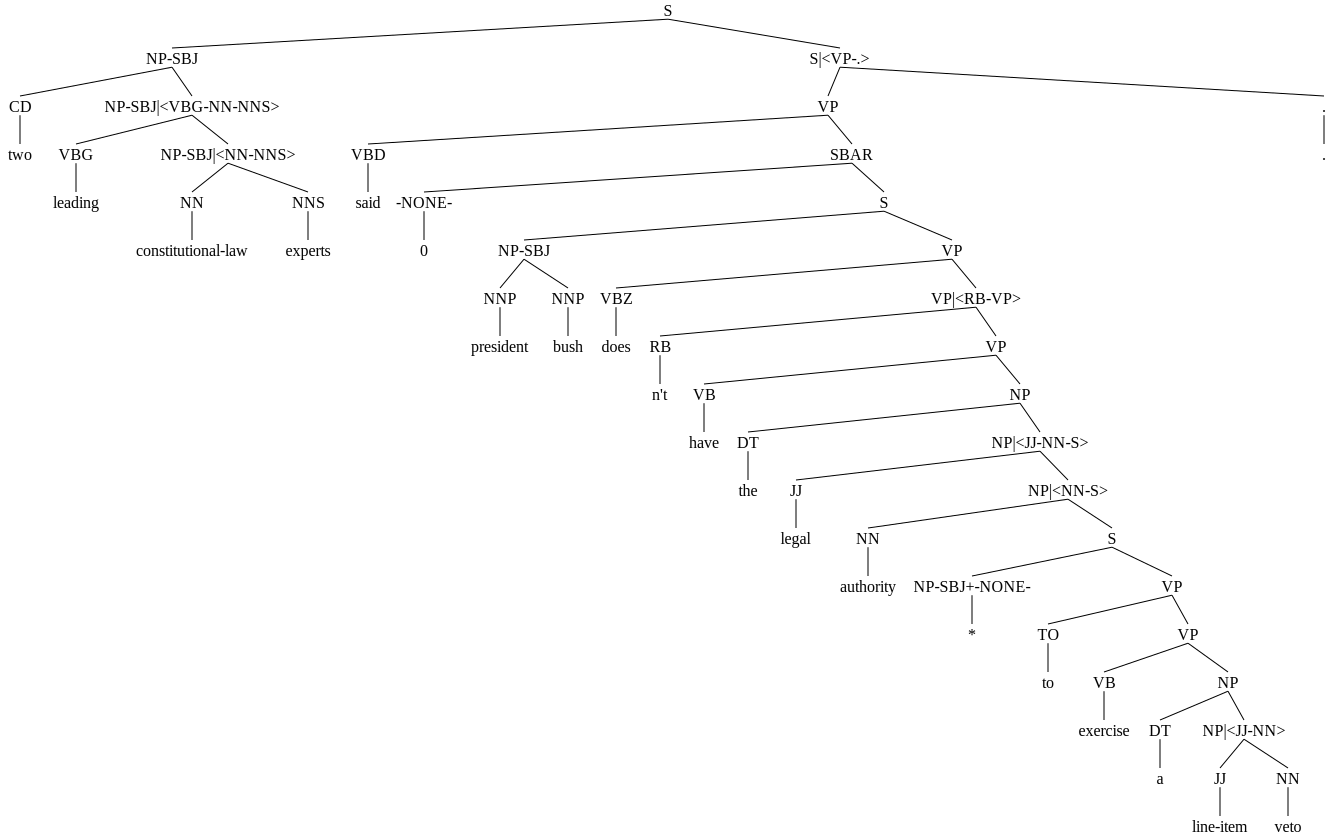

In [27]:
test_tree = build_tree(test_back, (0, len(test_sent), 'S'))
test_tree

## Question 11
Run the remaining code to test your model on test data "cnf_test".

In [28]:
def set_leave_index(tree):
    '''
    Label the leaves of the tree with indexes
    Arg:
        tree: original tree, nltk.tree.Tree
    Return:
        tree: preprocessed tree, nltk.tree.Tree
    '''
    for idx, _ in enumerate(tree.leaves()):
        tree_location = tree.leaf_treeposition(idx)
        non_terminal = tree[tree_location[:-1]]
        non_terminal[0] = non_terminal[0] + "_" + str(idx)
    return tree

def get_nonterminal_bracket(tree):
    '''
    Obtain the constituent brackets of a tree
    Arg:
        tree: tree, nltk.tree.Tree
    Return:
        nonterminal_brackets: constituent brackets, set
    '''
    nonterminal_brackets = set()
    for tr in tree.subtrees():
        label = tr.label()
        #print(tr.leaves())
        if len(tr.leaves()) == 0:
            continue
        start = tr.leaves()[0].split('_')[-1]
        end = tr.leaves()[-1].split('_')[-1]
        if start != end:
            nonterminal_brackets.add(label+'-('+start+':'+end+')')
    return nonterminal_brackets

def word2lower(w, terminals):
    '''
    Map an unknow word to "unk"
    '''
    return w.lower() if w in terminals else '<unk>'

In [29]:
correct_count = 0
pred_count = 0
gold_count = 0
for i, t in enumerate(cnf_test):
    #Protect the original tree 
    t = copy.deepcopy(t)
    sent = t.leaves()  
    #Map the unknow words to "unk"
    sent = [word2lower(w.lower(), terminals) for w in sent]
    
    #CKY algorithm
    score, back = CKY(sent, s_rules_prob)
    candidate_tree = build_tree(back, (0, len(sent), 'S')) #, nonterminals)
    
    #Extract constituents from the gold tree and predicted tree
    pred_tree = set_leave_index(candidate_tree)
    pred_brackets = get_nonterminal_bracket(pred_tree)
    
    #Count correct constituents
    pred_count += len(pred_brackets)
    gold_tree = set_leave_index(t)
    gold_brackets = get_nonterminal_bracket(gold_tree)
    gold_count += len(gold_brackets)
    current_correct_num = len(pred_brackets.intersection(gold_brackets))
    correct_count += current_correct_num
    
    print('#'*20)
    print('Test Tree:', i+1)
    print('Constituent number in the predicted tree:', len(pred_brackets))
    print('Constituent number in the gold tree:', len(gold_brackets))
    print('Correct constituent number:', current_correct_num)

recall = correct_count/gold_count
precision = correct_count/pred_count
f1 = 2*recall*precision/(recall+precision)

####################
Test Tree: 1
Constituent number in the predicted tree: 20
Constituent number in the gold tree: 20
Correct constituent number: 14
####################
Test Tree: 2
Constituent number in the predicted tree: 54
Constituent number in the gold tree: 54
Correct constituent number: 30
####################
Test Tree: 3
Constituent number in the predicted tree: 30
Constituent number in the gold tree: 30
Correct constituent number: 23
####################
Test Tree: 4
Constituent number in the predicted tree: 17
Constituent number in the gold tree: 17
Correct constituent number: 16
####################
Test Tree: 5
Constituent number in the predicted tree: 32
Constituent number in the gold tree: 32
Correct constituent number: 26
####################
Test Tree: 6
Constituent number in the predicted tree: 40
Constituent number in the gold tree: 40
Correct constituent number: 18
####################
Test Tree: 7
Constituent number in the predicted tree: 22
Constituent number in

In [30]:
print('Overall precision: {:.3f}, recall: {:.3f}, f1: {:.3f}'.format(precision, recall, f1))

Overall precision: 0.545, recall: 0.545, f1: 0.545
